In [28]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from skimage import measure

def load_lora_weights(model, lora_path):
    lora_state = torch.load(lora_path)
    for name, param in model.named_parameters():
        if name in lora_state:
            param.data = lora_state[name]
    return model

def get_points_from_image(image, num_points=2):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    coords = np.column_stack(np.where(edges > 0))
    if len(coords) > num_points:
        points = coords[np.random.choice(len(coords), num_points, replace=False)]
    else:
        points = coords
    points = points[:, [1, 0]]
    return points

def inference(predictor, image_path, lora_path=None, device="cuda"):
    if lora_path:
        predictor.model = load_lora_weights(predictor.model, lora_path)
    predictor.model.to(device)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    points = get_points_from_image(image)

    predictor.set_image(image)
    input_point = np.array(points)
    input_label = np.ones(input_point.shape[0])

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True
    )

    return image, masks, scores

def load_ground_truth_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return mask > 0

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0

def visualize_results(image, masks, scores, gt_mask, title):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    best_mask_index = np.argmax(scores)
    best_mask = masks[best_mask_index]
    plt.imshow(best_mask, cmap='gray')
    plt.title(f"Best Predicted Mask - {title}\nScore: {scores[best_mask_index]:.2f}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

dataset/Lucchi++/Test_Out\39.png
Best IoU without LoRA: 0.0000
Best IoU with LoRA: 0.0253


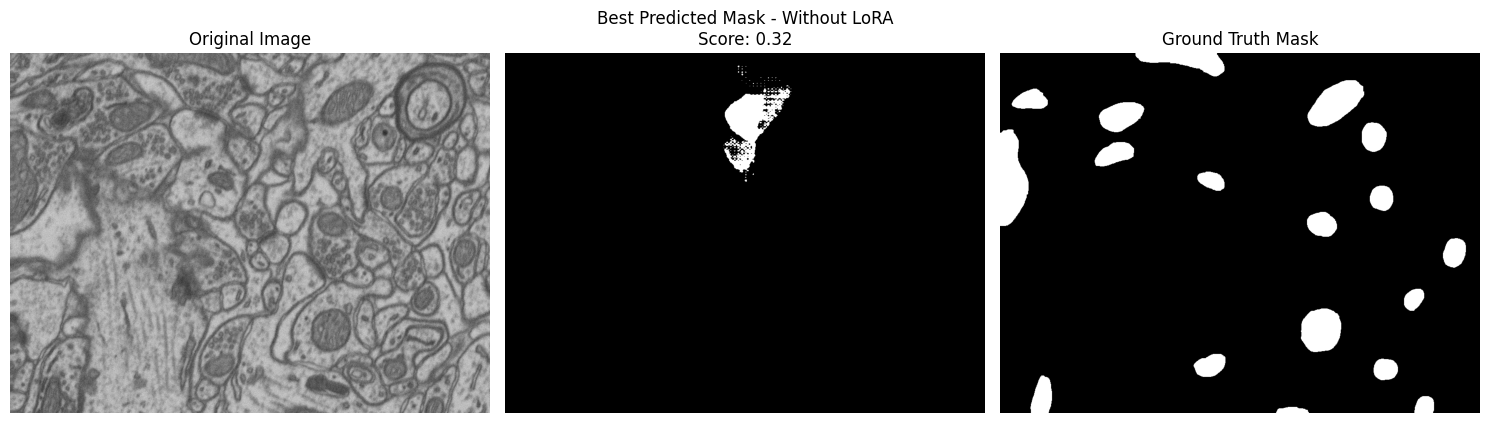

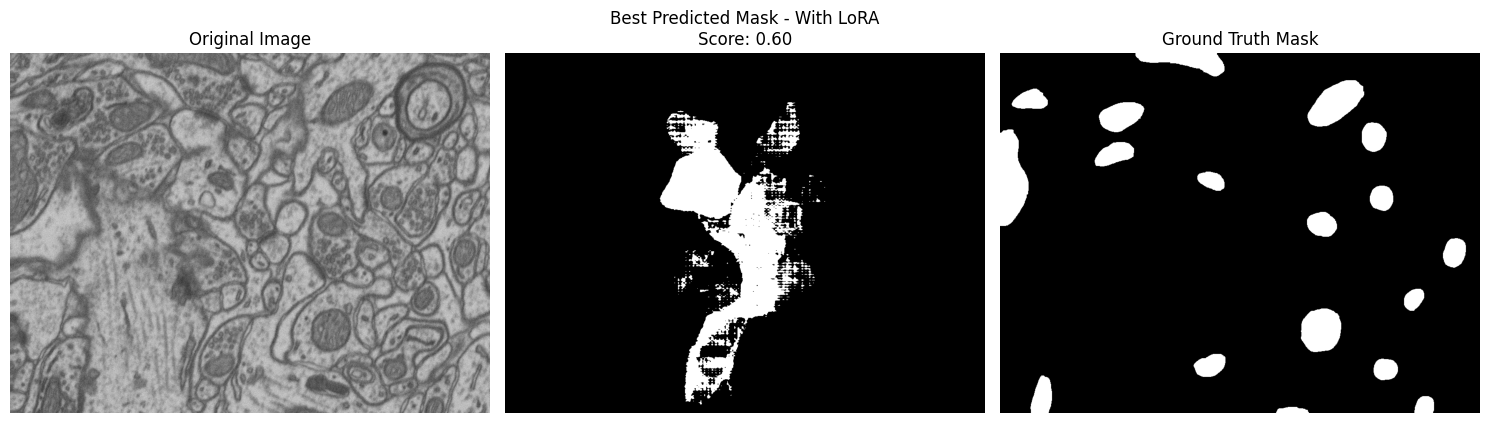

In [29]:
import re

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
    lora_path = "sam2_lora_checkpoint_1000.pth"

    predictor = SAM2ImagePredictor(build_sam2(model_cfg, sam2_checkpoint, device=device))

    test_images_dir = "dataset/Lucchi++/Test_In"
    test_masks_dir = "dataset/Lucchi++/Test_Out"

    test_image = np.random.choice(os.listdir(test_images_dir))
    test_image_path = os.path.join(test_images_dir, test_image)
    tg = re.sub(r'^mask(0*)(\d+\.png)$', r'\2',  test_image)

    test_mask_path = os.path.join(test_masks_dir, f"{tg}")

    # Without LoRA
    image, masks_without_lora, scores_without_lora = inference(predictor, test_image_path)

    # With LoRA
    image, masks_with_lora, scores_with_lora = inference(predictor, test_image_path, lora_path)

    # Load ground truth mask
    print(test_mask_path)
    gt_mask = load_ground_truth_mask(test_mask_path)

    # Calculate IoU for both cases
    iou_without_lora = max(calculate_iou(mask, gt_mask) for mask in masks_without_lora)
    iou_with_lora = max(calculate_iou(mask, gt_mask) for mask in masks_with_lora)

    print(f"Best IoU without LoRA: {iou_without_lora:.4f}")
    print(f"Best IoU with LoRA: {iou_with_lora:.4f}")

    # Visualize results
    visualize_results(image, masks_without_lora, scores_without_lora, gt_mask, "Without LoRA")
    visualize_results(image, masks_with_lora, scores_with_lora, gt_mask, "With LoRA")